<a href="https://colab.research.google.com/github/GabrielaRomoM/SIGNALS-THEORY_2024-1/blob/main/NNPSD_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from tabulate import tabulate
import time
import tracemalloc
from IPython.display import clear_output
from scipy.stats import norm

# Funciones

## Generación de señales y calculo de PSD (Welch)

In [ ]:
def senal(f=1, T=3, N=512):
  """
Esta función genera una señal senoidal con 3 armonicos.

Entradas:
f: Frecuencia de la señal
T: Duración de la señal
N: Número de puntos en la señal

Salidas:
t: Vector de tiempo
xt: Señal senoidal con 3 armonicos
fs: Frecuencia de muestreo
N: Número de puntos en la señal
  """
  w = 2 * np.pi * f
  fs = N / T
  t = np.linspace(0, T, N)

  # Señales particulares
  x1 = np.cos(w * t)
  x2 = 1/3 * (np.sin(3 * w * t))
  x3 = 1/5 * (np.sin(5 * w * t))

  # Señal original para la red
  xt = x1 - x2 + x3

  return t, xt, fs, N

def matrizruidosa(xt, stds, num_signals):
  """
Esta función genera una matriz de señales ruidosas con diferentes niveles de ruido.

Entradas:
xt: Señal senoidal con 3 armonicos
stds: Lista de niveles de ruido
num_signals: Número de señales en la matriz

Salidas:
matriz: Matriz de señales ruidosas
  """
  N = len(xt)
  matriz = []
  for std in stds:
    for _ in range(num_signals):
            noise = np.random.normal(0, std, N)
            noisy_signal = xt + noise
            matriz.append(noisy_signal)
  return np.array(matriz)

def psd(signals, fs, nperseg):
  """
Esta función calcula la potencia espectral de cada señal en la matriz.

Entradas:
signals: Matriz de señales
fs: Frecuencia de muestreo
nperseg: Número de segmentos para la transformada de Fourier

Salidas:
fr: Vector de frecuencias
PSD: Potencia espectral de cada señal
  """
  fr, PSD = signal.welch(signals, fs=fs, nperseg=nperseg)
  return fr, PSD

def promediopsd(*psd_matrices):
  """
Esta función calcula el promedio de la potencia espectral de cada señal en la matriz.

Entradas:
*psd_matrices: Tupla de matrices de potencia espectral

Salidas:
promedios: Lista de promedios de potencia espectral
  """
  promedios = [np.mean(matriz, axis=0) for matriz in psd_matrices]
  return promedios

def psdpromedio(PSDprom1, PSDprom2):
  """
Esta función calcula el promedio de la potencia espectral de cada señal en la matriz.

Entradas:
PSDprom1: Potencia espectral de la matriz 1
PSDprom2: Potencia espectral de la matriz 2

Salidas:
PSDpromm1: Potencia espectral promedio de la matriz 1
PSDpromm2: Potencia espectral promedio de la matriz 2
  """
  PSDpromm1 = np.tile(PSDprom1, (129, 1))
  PSDpromm2 = np.tile(PSDprom2, (130, 1))
  return PSDpromm1, PSDpromm2

t, xt, fs, N = senal()
M1 = matrizruidosa(xt, stds=[0.1,0.3,0.5], num_signals=43)
M2 = matrizruidosa(xt, stds=[1, 3, 5, 10, 30], num_signals=26)
fr, Wt = psd(xt, fs, N)
fr, W1= psd(M1, fs, N)
fr, W2 = psd(M2, fs, N)
PSDprom1, PSDprom2 = promediopsd(W1, W2)
PSDpromm1, PSDpromm2 = psdpromedio(PSDprom1, PSDprom2)

def plotpsd(fr, W1,W2, Wt):
  """
Esta función grafica la potencia espectral de cada señal en la matriz.

Entradas:
fr: Vector de frecuencias
W1: Potencia espectral de la matriz 1
W2: Potencia espectral de la matriz 2
Wt: Potencia espectral de la señal original

Salidas:
Gráfica de la potencia espectral de cada señal en la matriz
  """
  plt.figure(figsize=(12,6))
  plt.title('PSD de las señales')
  plt.xlabel('Frecuencia (Hz)')
  plt.ylabel('PSD')
  plt.semilogy(fr, W2[86], 'y', label='Señal con ruido 30')
  plt.semilogy(fr, W2[66], 'b', label='Señal con ruido 10')
  plt.semilogy(fr, W2[46], 'm', label='Señal con ruido 5')
  plt.semilogy(fr, W2[26], 'g', label='Señal con ruido 3')
  plt.semilogy(fr, W2[0], 'r', label='Señal con ruido 1')
  plt.semilogy(fr, W1[86], 'm', label="PSD con ruido 0.5")
  plt.semilogy(fr, W1[43], 'g', label="PSD con ruido 0.3")
  plt.semilogy(fr, W1[0], 'r', label="PSD con ruido 0.1")
  plt.semilogy(fr, Wt, 'y', label="PSD sin ruido")
  plt.xlim(0, 8)
  plt.ylim(10**-5, 0)
  plt.grid(True)
  plt.legend()
  plt.show()

## Redes Neuronales MLP, LSTM

In [ ]:
# Función para realizar la separación de datos
def datos(M1, PSDpromm1, M2, PSDpromm2):
    """
Esta función separa los datos en conjuntos de entrenamiento y prueba.

Entradas:
M1: Matriz de señales ruidosas con ruido 0.1, 0.3, 0.5
PSDpromm1: Potencia espectral promedio de la matriz 1
M2: Matriz de señales ruidosas con ruido

Salidas:
x_train, x_test, y_train, y_test: Conjuntos de entrenamiento y prueba
  """
    x_train, x_test, y_train, y_test = train_test_split(M1, PSDpromm1, test_size=0.3, random_state=40)
    x_train2, x_test2, y_train2, y_test2 = train_test_split(M2, PSDpromm2, test_size=0.3, random_state=40)

    return x_train, x_test, y_train, y_test, x_train2, x_test2, y_train2, y_test2

def escalardatos(x_train, x_test, x_train2, x_test2):
    """
Esta función escala los datos utilizando MinMaxScaler.

Entradas:
x_train: Conjunto de entrenamiento
x_test: Conjunto de prueba
x_train2: Conjunto de entrenamiento 2
x_test2: Conjunto de prueba 2

Salidas:
X_train_scaled: Conjunto de entrenamiento escalado
X_test_scaled: Conjunto de prueba escalado
X_train_scaled2: Conjunto de entrenamiento 2 escalado
X_test_scaled2: Conjunto de prueba 2 escalado
  """
    scaler1 = MinMaxScaler()
    X_train_scaled = scaler1.fit_transform(x_train).reshape(-1, N)
    X_test_scaled = scaler1.transform(x_test).reshape(-1, N)

    scaler2 = MinMaxScaler()
    X_train_scaled2 = scaler2.fit_transform(x_train2).reshape(-1, N)
    X_test_scaled2 = scaler2.transform(x_test2).reshape(-1, N)

    return X_train_scaled, X_test_scaled, X_train_scaled2, X_test_scaled2

# Función para crear y entrenar modelo MLP
def entrenar_mlp(x_train, y_train):
    """
Esta función crea y entrena un modelo MLP.

Entradas:
x_train: Conjunto de entrenamiento
y_train: Conjunto de prueba

Salidas:
model1: Modelo MLP
history1: Historial de entrenamiento
training_time1: Tiempo de entrenamiento
memory_usage1: Uso de memoria
  """
    model1 = Sequential()
    model1.add(Dense(128, activation='elu', input_shape=(512,)))
    model1.add(Dense(257, activation='linear'))

    model1.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy', 'mae'])
    start_time = time.time()
    tracemalloc.start()
    history1 = model1.fit(x_train, y_train, epochs=30, validation_split=0.3)
    training_time1 = time.time() - start_time
    memory_usage1 = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()
    clear_output()
    return model1, history1, training_time1, memory_usage1

def entrenar_mlp2(x_train, y_train):
    """
Esta función crea y entrena un modelo MLP.

Entradas:
x_train: Conjunto de entrenamiento
y_train: Conjunto de prueba

Salidas:
model2: Modelo MLP
history2: Historial de entrenamiento
training_time2: Tiempo de entrenamiento
memory_usage2: Uso de memoria
  """
    model2 = Sequential()
    model2.add(Dense(512, activation='relu', input_shape=(512,)))
    model2.add(Dense(256, activation='relu'))
    #model2.add(Dense(128, activation='elu'))
    model2.add(Dense(257, activation='linear'))

    model2.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy', 'mae'])
    start_time = time.time()
    tracemalloc.start()
    history2 = model2.fit(x_train, y_train, epochs=30, batch_size=4, validation_split=0.3)
    training_time2 = time.time() - start_time
    memory_usage2 = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()
    clear_output()
    return model2, history2, training_time2, memory_usage2

# Función para crear y entrenar modelo LSTM
def entrenar_lstm(X_train_scaled, y_train):
    """
Esta función crea y entrena un modelo LSTM.

Entradas:
X_train_scaled: Conjunto de entrenamiento escalado
y_train: Conjunto de prueba

Salidas:
model3: Modelo LSTM
history3: Historial de entrenamiento
training_time3: Tiempo de entrenamiento
memory_usage3: Uso de memoria
  """
    model3 = Sequential()
    model3.add(LSTM(128, input_shape=(N,1), return_sequences=False))
    model3.add(Dense(257, activation='linear'))
    model3.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy', 'mae'])
    start_time = time.time()
    tracemalloc.start()
    history3 = model3.fit(X_train_scaled, y_train, epochs=10, validation_split=0.3)
    training_time3 = time.time() - start_time
    memory_usage3 = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()
    clear_output()
    return model3, history3, training_time3, memory_usage3

# Función para crear y entrenar modelo LSTM
def entrenar_lstm2(X_train_scaled, y_train):
    """
Esta función crea y entrena un modelo LSTM.

Entradas:
X_train_scaled: Conjunto de entrenamiento escalado
y_train: Conjunto de prueba

Salidas:
model3: Modelo LSTM
history3: Historial de entrenamiento
training_time3: Tiempo de entrenamiento
memory_usage3: Uso de memoria
  """
    model4 = Sequential()
    model4.add(LSTM(256, input_shape=(N,1), return_sequences=False))
    model4.add(Dense(257, activation='linear'))
    model4.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy', 'mae'])
    start_time = time.time()
    tracemalloc.start()
    history4 = model4.fit(X_train_scaled, y_train, epochs=10, validation_split=0.3)
    training_time4 = time.time() - start_time
    memory_usage4 = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()
    clear_output()
    return model4, history4, training_time4, memory_usage4

# Paso 1: Separar los datos
x_train, x_test, y_train, y_test, x_train2, x_test2, y_train2, y_test2 = datos(M1, PSDpromm1, M2, PSDpromm2)

# Paso 2: Escalar los datos
X_train_scaled, X_test_scaled, X_train_scaled2, X_test_scaled2 = escalardatos(x_train, x_test, x_train2, x_test2)

In [ ]:
# MLP (0.1,0.3,0.5)
model1, history1, training_time1, memory_usage1 = entrenar_mlp(x_train, y_train)
# MLP(1,3,5,10,30)
model2, history2, training_time2, memory_usage2 = entrenar_mlp2(x_train2, y_train2)
# LSTM (0.1,0.3,0.5)
model3, history3, training_time3, memory_usage3 = entrenar_lstm(X_train_scaled, y_train)
# LSTM (1,3,5,10,30)
model4, history4, training_time4, memory_usage4 = entrenar_lstm2(X_train_scaled2, y_train2)

## Tablas y Gráficos (Errores L1,L2,RMSE, Tiempo, Memoria)

In [ ]:
def tablaserror():
    """
Esta función genera tablas de error para cada red.
Entradas:
  history1: Historial de entrenamiento de la red 1
  history2: Historial de entrenamiento de la red 2
  history3: Historial de entrenamiento de la red 3
  history4: Historial de entrenamiento de la red 4

Salidas:
  Gráfica de las tablas de error
  """
    # Obtener los historiales de las cuatro redes
    mse_history_1 = history1.history['loss']
    mae_history_1 = history1.history['mae']

    mse_history_2 = history2.history['loss']
    mae_history_2 = history2.history['mae']

    mse_history_3 = history3.history['loss']
    mae_history_3 = history3.history['mae']

    mse_history_4 = history4.history['loss']
    mae_history_4 = history4.history['mae']

    # Calcular RMSE para cada red
    rmse_history_1 = [np.sqrt(value) for value in mse_history_1]
    rmse_history_2 = [np.sqrt(value) for value in mse_history_2]
    rmse_history_3 = [np.sqrt(value) for value in mse_history_3]
    rmse_history_4 = [np.sqrt(value) for value in mse_history_4]

    # Crear DataFrames para las cuatro tablas con épocas como columnas

    data_1 = {
        'MSE-L2': mse_history_1,
        'MAE-L1': mae_history_1,
        'RMSE': rmse_history_1,
    }

    data_2 = {
        'MSE-L2': mse_history_2,
        'MAE-L1': mae_history_2,
        'RMSE': rmse_history_2,
    }

    data_3 = {
        'MSE-L2': mse_history_3,
        'MAE-L1': mae_history_3,
        'RMSE': rmse_history_3,
    }

    data_4 = {
        'MSE-L2 LSTM 2': mse_history_4,
        'MAE-L1 LSTM 2': mae_history_4,
        'RMSE LSTM 2': rmse_history_4,
    }

    # Agregar la fila de "Promedio" como última columna
    epoch_labels = list(range(1, len(mse_history_1)+ 1))
    epoch_labels2 = list(range(1, len(mse_history_3)+ 1))

    df_1 = pd.DataFrame(data_1, index=epoch_labels).T
    df_2 = pd.DataFrame(data_2, index=epoch_labels).T
    df_3 = pd.DataFrame(data_3, index=epoch_labels2).T
    df_4 = pd.DataFrame(data_4, index=epoch_labels2).T

    # Convertir las tablas a texto con tabulate
    table_1 = tabulate(df_1, headers='keys', tablefmt='fancy_grid')
    table_2 = tabulate(df_2, headers='keys', tablefmt='fancy_grid')
    table_3 = tabulate(df_3, headers='keys', tablefmt='fancy_grid')
    table_4 = tabulate(df_4, headers='keys', tablefmt='fancy_grid')

    # Imprimir las tablas una debajo de la otra
    print("Tabla 1: MLP 1\n", table_1, "\n")
    print("Tabla 2: MLP 2\n", table_2, "\n")
    print("Tabla 3: LSTM 1\n", table_3, "\n")
    print("Tabla 4: LSTM 2\n", table_4, "\n")

def tablaresumen():
      """
Esta función genera una tabla resumen de los errores y tiempos de entrenamiento para cada red.

Entradas:
model1: Modelo MLP
history1: Historial de entrenamiento
training_time1: Tiempo de entrenamiento
memory_usage1: Uso de memoria

Salidas:
  Gráfica de la tabla resumen
  """
      # Definir los ruidos aplicados a cada red
      ruido1_3 = [0.1, 0.3, 0.5]
      ruido2_4 = [1, 3, 5, 10, 30]

      # Crear una lista para almacenar los datos de la tabla
      datos_tabla = []

      # Agregar los datos de cada red
      for i, (model, history, training_time, memory_usage, ruido) in enumerate([
         (model1, history1, training_time1, memory_usage1, ruido1_3),
         (model2, history2, training_time2, memory_usage2, ruido2_4),
         (model3, history3, training_time3, memory_usage3, ruido1_3),
         (model4, history4, training_time4, memory_usage4, ruido2_4),
      ]):

        # Calcular los valores de MSE, MAE y RMSE
        mse_history = history.history['loss']
        mae_history = history.history['mae']
        rmse_history = [np.sqrt(value) for value in mse_history]

        mse_mean = sum(mse_history) / len(mse_history)
        mae_mean = sum(mae_history) / len(mae_history)
        rmse_mean = sum(rmse_history) / len(rmse_history)

        # Calcular los valores de evaluación y precisión
        evaluation = history.history['val_loss'][-1]  # Último valor de validación de la pérdida
        precision = history.history['val_accuracy'][-1]  # Último valor de precisión de validación

        # Calcular el error entre muestra y error promedio de las muestras
        error_entre_muestra = evaluation  # Puedes ajustar este cálculo si es necesario
        error_promedio_muestras = np.mean(history.history['val_mae'])  # Promedio de los errores absolutos medios

        # Definir los datos de la fila
        fila = {
            'Red': f'Red {i+1}',
            'Longitud señal': M1.shape[1] if i < 2 else M2.shape[1],
            'Num señales': x_train.shape[0] if i < 2 else x_train2.shape[0],
            'Ruido': str(ruido),
            'MSE L2 Promedio': mse_mean,
            'MAE L1 Promedio': mae_mean,
            'RMSE Promedio': rmse_mean,
            'Tiempo entrenamiento (s)': training_time,
            'Uso memoria (MB)': memory_usage / (1024 ** 2),  # Convertir bytes a MB
            'Error entre muestra': error_entre_muestra,
            'Error prom de las muestras': error_promedio_muestras
        }

        # Agregar la fila a la lista de datos
        datos_tabla.append(fila)

        # Convertir la lista de datos en un DataFrame
        df_resumen = pd.DataFrame(datos_tabla)

         # Convertir el DataFrame a una tabla con formato tabulado
        tabla_resumen = tabulate(df_resumen, headers='keys', tablefmt='fancy_grid')

      # Imprimir la tabla
      print(tabla_resumen)

def graficoerrores():
        """
Esta función grafica las curvas de error para cada red.

Entradas:
  history1: Historial de entrenamiento de la red 1
  history2: Historial de entrenamiento de la red 2
  history3: Historial de entrenamiento de la red 3
  history4: Historial de entrenamiento de la red 4

Salidas:
  Gráfica de las curvas de error
  """
        # Obtener los historiales de las cuatro redes
        mse_history_1 = history1.history['loss']
        mae_history_1 = history1.history['mae']

        mse_history_2 = history2.history['loss']
        mae_history_2 = history2.history['mae']

        mse_history_3 = history3.history['loss']
        mae_history_3 = history3.history['mae']

        mse_history_4 = history4.history['loss']
        mae_history_4 = history4.history['mae']

        # Calcular RMSE para cada red
        rmse_history_1 = [np.sqrt(value) for value in mse_history_1]
        rmse_history_2 = [np.sqrt(value) for value in mse_history_2]
        rmse_history_3 = [np.sqrt(value) for value in mse_history_3]
        rmse_history_4 = [np.sqrt(value) for value in mse_history_4]

        # Crear una figura con cuatro subplots (dos filas, dos columnas)
        fig, axs = plt.subplots(1, 2, figsize=(16, 5))

        # Gráfico 1: MLP
        axs[0].semilogy(range(1, len(mse_history_1) + 1), mse_history_1, label='MSE Ruidos Bajos', color='blue', marker='.')
        axs[0].semilogy(range(1, len(mae_history_1) + 1), mae_history_1, label='MAE Ruidos Bajos', color='green', marker='.')
        axs[0].semilogy(range(1, len(rmse_history_1) + 1), rmse_history_1, label='RMSE Ruidos Bajos', color='red', marker='.')
        axs[0].semilogy(range(1, len(mse_history_2) + 1), mse_history_2, label='MSE Ruidos Altos', color='yellow', marker='.')
        axs[0].semilogy(range(1, len(mae_history_2) + 1), mae_history_2, label='MAE Ruidos Altos', color='orange', marker='.')
        axs[0].semilogy(range(1, len(rmse_history_2) + 1), rmse_history_2, label='RMSE Ruidos Altos', color='black', marker='.')
        axs[0].set_title('Logarithmic Plot of Errors MLP')
        #axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Error')
        #axs[0].set_ylim(0,)
        axs[0].legend()

        # Gráfico 2: LSTM
        axs[1].semilogy(range(1, len(mse_history_3) + 1), mse_history_3, label='MSE Ruidos Bajos', color='blue', marker='.')
        axs[1].semilogy(range(1, len(mae_history_3) + 1), mae_history_3, label='MAE Ruidos Bajos', color='green', marker='.')
        axs[1].semilogy(range(1, len(rmse_history_3) + 1), rmse_history_3, label='RMSE Ruidos Bajos', color='red', marker='.')
        axs[1].semilogy(range(1, len(mse_history_4) + 1), mse_history_4, label='MSE Ruidos Altos', color='yellow', marker='.')
        axs[1].semilogy(range(1, len(mae_history_4) + 1), mae_history_4, label='MAE Ruidos Altos', color='orange', marker='.')
        axs[1].semilogy(range(1, len(rmse_history_4) + 1), rmse_history_4, label='RMSE Ruidos Altos', color='black', marker='.')
        axs[1].set_title('Logarithmic Plot of Errors LSTM')
        #axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Error')
        axs[1].legend()

        # Ajustar el diseño y mostrar las gráficas
        plt.tight_layout()
        plt.show()

## Reconstrucción de la señal

In [ ]:
# Generar predicciones para las cuatro redes
y =  model1.predict(x_test)
y1 = model2.predict(x_test2)
y2 = model3.predict(x_test)
y3 = model4.predict(x_test2)

def psdresultados():
      """
Esta función grafica las predicciones de las cuatro redes.

Entradas:
  y: Predicciones de la red 1
  y1: Predicciones de la red 2
  y2: Predicciones de la red 3
  y3: Predicciones de la red 4

Salidas:
  Gráfica de las predicciones
  """
      # Crear una figura con cuatro subplots organizados en dos filas
      fig, axs = plt.subplots(1, 2, figsize=(16, 5))

      # Gráfico 1: PSD de las señales ruidos (0.1,0.3,0.5)
      axs[0].semilogy(fr, y[0], 'b', label="PSD predicha MLP (0.1,0.3,0.5)")
      axs[0].semilogy(fr, y2[0], 'r', label="PSD predicha LSTM (0.1,0.3, 0.5)")
      axs[0].semilogy(fr, y_test[0], 'y', label="PSD original (0.1,0.3, 0.5)")
      axs[0].set_title('PSD de las señales ruidos (0.1,0.3,0.5)')
      axs[0].set_xlabel('Frecuencia (Hz)')
      axs[0].set_ylabel('PSD')
      axs[0].set_xlim(0, 8)
      axs[0].grid(True)
      axs[0].legend()

     # Gráfico 2: PSD de las señales ruidos (1,3,5,10,30)
      axs[1].semilogy(fr, y1[0], 'b', label="PSD predicha MLP (1,3,5,10,30)")
      axs[1].semilogy(fr, y3[0], 'r', label="PSD predicha LSTM (1,3,5,10,30)")
      axs[1].semilogy(fr, y_test[0], 'y', label="PSD original (1,3,5,10,30)")
      axs[1].set_title('PSD de las señales ruidos (1,3,5,10,30)')
      axs[1].set_xlabel('Frecuencia (Hz)')
      axs[1].set_ylabel('PSD')
      axs[1].set_xlim(0, 8)
      axs[1].grid(True)
      axs[1].legend()

      # Ajustar el diseño y mostrar las gráficas
      plt.tight_layout()
      plt.show()

def reconst(point,y,y1,y2,y3):
  """
  Esta función reconstruye las señales predichas en el dominio del tiempo
  en base a su potencia en las frecuencia conocidas, luego grafica todas las
  señales.

  Entradas:
  point: Número de señal que tomaremos en las predicciones
  y1: Predicción 1 (MLP ruidos 0.1,0.3,0.5)
  y2: Predicción 2 (MLP ruidos 1,3,5,10,30)
  y3: Predicción 3 (LSTM ruidos 0.1,0.3,0.5)
  y4: Predicción 4 (LSTM ruidos 1,3,5,10,30)

  Salidas:
  xt_1, xt_2, xt_3, xt_4: Señales reconstruidas
  Gráfica de todas las señales
  """
  #Datos iniciales
  w = 2*np.pi
  T = 3
  #Armónicos en 1Hz
  potencia1_1 = y[point][np.argmin(np.abs(fr - 1))]
  potencia1_2 = y1[point][np.argmin(np.abs(fr - 1))]
  potencia1_3 = y2[point][np.argmin(np.abs(fr - 1))]
  potencia1_4 = y3[point][np.argmin(np.abs(fr - 1))]

  #Armónicos en 3Hz
  potencia2_1 = y[point][np.argmin(np.abs(fr - 3))]
  potencia2_2 = y1[point][np.argmin(np.abs(fr - 3))]
  potencia2_3 = y2[point][np.argmin(np.abs(fr - 3))]
  potencia2_4 = y3[point][np.argmin(np.abs(fr - 3))]

  #Armónicos en 5Hz
  potencia3_1 = y[point][np.argmin(np.abs(fr - 5))]
  potencia3_2 = y1[point][np.argmin(np.abs(fr - 5))]
  potencia3_3 = y2[point][np.argmin(np.abs(fr - 5))]
  potencia3_4 = y3[point][np.argmin(np.abs(fr - 5))]

  xt_1 = (np.sqrt(np.abs(potencia1_1))*(np.cos(w*t))) - (np.sqrt(np.abs(potencia2_1))*(np.sin(3*w*t))) + (np.sqrt(np.abs(potencia3_1))*(np.sin(5*w*t)))
  xt_2 = (np.sqrt(np.abs(potencia1_2))*(np.cos(w*t))) - (np.sqrt(np.abs(potencia2_2))*(np.sin(3*w*t))) + (np.sqrt(np.abs(potencia3_2))*(np.sin(5*w*t)))
  xt_3 = (np.sqrt(np.abs(potencia1_3))*(np.cos(w*t))) - (np.sqrt(np.abs(potencia2_3))*(np.sin(3*w*t))) + (np.sqrt(np.abs(potencia3_3))*(np.sin(5*w*t)))
  xt_4 = (np.sqrt(np.abs(potencia1_4))*(np.cos(w*t))) - (np.sqrt(np.abs(potencia2_4))*(np.sin(3*w*t))) + (np.sqrt(np.abs(potencia3_4))*(np.sin(5*w*t)))

  plt.figure(figsize=(16,5))
  plt.plot(t,xt,label='Original')
  plt.plot(t,xt_1,label='Prediccion 1')
  plt.plot(t,xt_2,label='Prediccion 2')
  plt.plot(t,xt_3,label='Prediccion 3')
  plt.plot(t,xt_4,label='Prediccion 4')
  plt.title('Reconstrucción en el tiempo')
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


## Implementación del umbral e histograma por armonico

In [ ]:
def umbral(signal):
    """
    Esta función grafica el histograma y el umbral percentil de una señal.

    Entradas:
    signal: Señal a analizar

    Salidas:
    Gráfica del histograma y el umbral percentil
    """
    # Calcular el histograma y el umbral percentil
    hist, bin_edges = np.histogram(signal, bins=50)
    percentile_threshold = 95
    threshold = np.percentile(signal, percentile_threshold)

    # Filtrar la señal según el umbral
    filtered_signal = np.where(signal >= threshold, signal, 0)

    # Encontrar el índice y frecuencia del armónico más alto
    idx_armonico = np.argmax(signal)
    freq_armonico = fr[idx_armonico]
    potencia_armonico = signal[idx_armonico]

    # Crear una figura con dos subplots en una fila
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    # Primer gráfico: Histograma de la señal con el umbral
    axs[0].set_title("Histograma")
    axs[0].hist(signal, bins=50, alpha=0.7, label='Señal original')
    axs[0].axvline(threshold, color='r', linestyle='dashed', linewidth=2, label=f'Umbral ({percentile_threshold}%)')
    axs[0].legend()

    # Segundo gráfico: Umbral en la señal y armónico más alto
    axs[1].set_title("Umbral para el primer armónico")
    axs[1].semilogy(fr, signal, label="PSD Señal")
    axs[1].axhline(threshold, color='r', linestyle='dashed', linewidth=2, label=f'Umbral ({percentile_threshold}%)')
    axs[1].scatter(freq_armonico, potencia_armonico, color='green', marker='x', s=100,
                   label=f'Armónico más alto\nFrecuencia: {freq_armonico} Hz\nPotencia: {potencia_armonico:.2f}')
    axs[1].set_xlim(0, 10)  # Ajusta los límites de la frecuencia según sea necesario
    axs[1].legend()

    # Ajustar el diseño y mostrar las gráficas
    plt.tight_layout()
    plt.show()

def armonicos(y):
  """
  Esta función grafica los armónicos de las señales predichas.

  Entradas:
  y: Predicciones

  Salidas:
  Gráfica de los armónicos
  """
  arm1 = []
  arm2 = []
  arm3 = []
  for i in range(0,len(y)):
    arm1.append(y[i][np.argmin(np.abs(fr - 1))])
    arm2.append(y[i][np.argmin(np.abs(fr - 3))])
    arm3.append(y[i][np.argmin(np.abs(fr - 5))])

  plt.figure(figsize=(16,5))
  # Histograma para Armónico 1
  counts1, bins1, _ = plt.hist(arm1, bins=50, alpha=0.7, label='Armónico 1', density=False)
  mean1, std1 = np.mean(arm1), np.std(arm1)
  x1 = np.linspace(min(bins1), max(bins1), 100)
  p1 = norm.pdf(x1, mean1, std1)
  p1 = p1 * max(counts1) / max(p1)  # Escalar la curva gaussiana
  plt.plot(x1, p1, 'b',linewidth=1)
  plt.legend()
  # Histograma para Armónico 2
  counts2, bins2, _ = plt.hist(arm2, bins=50, alpha=0.7, label='Armónico 2', density=False)
  mean2, std2 = np.mean(arm2), np.std(arm2)
  x2 = np.linspace(min(bins2), max(bins2), 100)
  p2 = norm.pdf(x2, mean2, std2)
  p2 = p2 * max(counts2) / max(p2)  # Escalar la curva gaussiana
  plt.plot(x2, p2, 'y',linewidth=1)
  plt.legend()
  # Histograma para Armónico 3
  counts3, bins3, _ = plt.hist(arm3, bins=50, alpha=0.7, label='Armónico 3', density=False)
  mean3, std3 = np.mean(arm3), np.std(arm3)
  x3 = np.linspace(min(bins3), max(bins3), 100)
  p3 = norm.pdf(x3, mean3, std3)
  p3 = p3 * max(counts3) / max(p3)  # Escalar la curva gaussiana
  plt.plot(x3, p3, 'g',linewidth=1)
  plt.legend()

# Resultados y Analisis

## Gráficos Señales originales, ruidosas y PSD (Iniciales)

<ipython-input-2-57a8587520f5>:132: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(10**-5, 0)


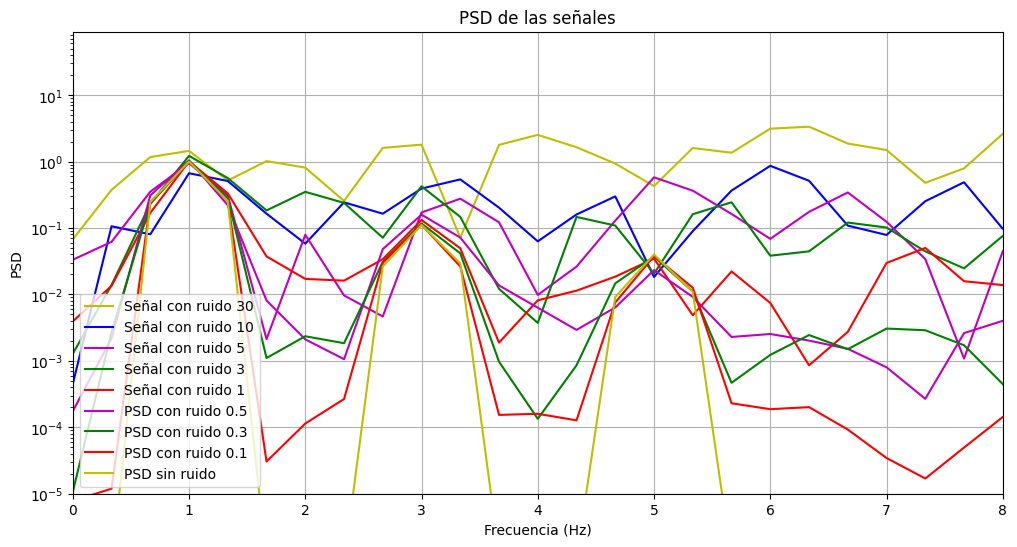

In [ ]:
plotpsd(fr,W1,W2,Wt)

## Umbral, Histogramas

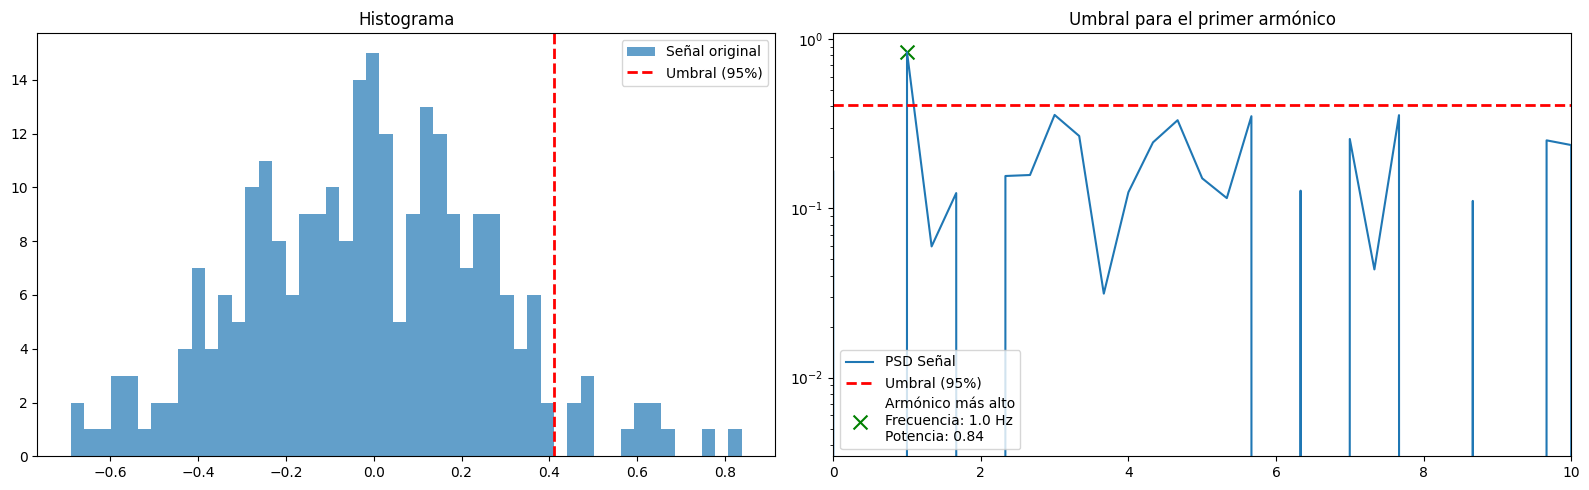

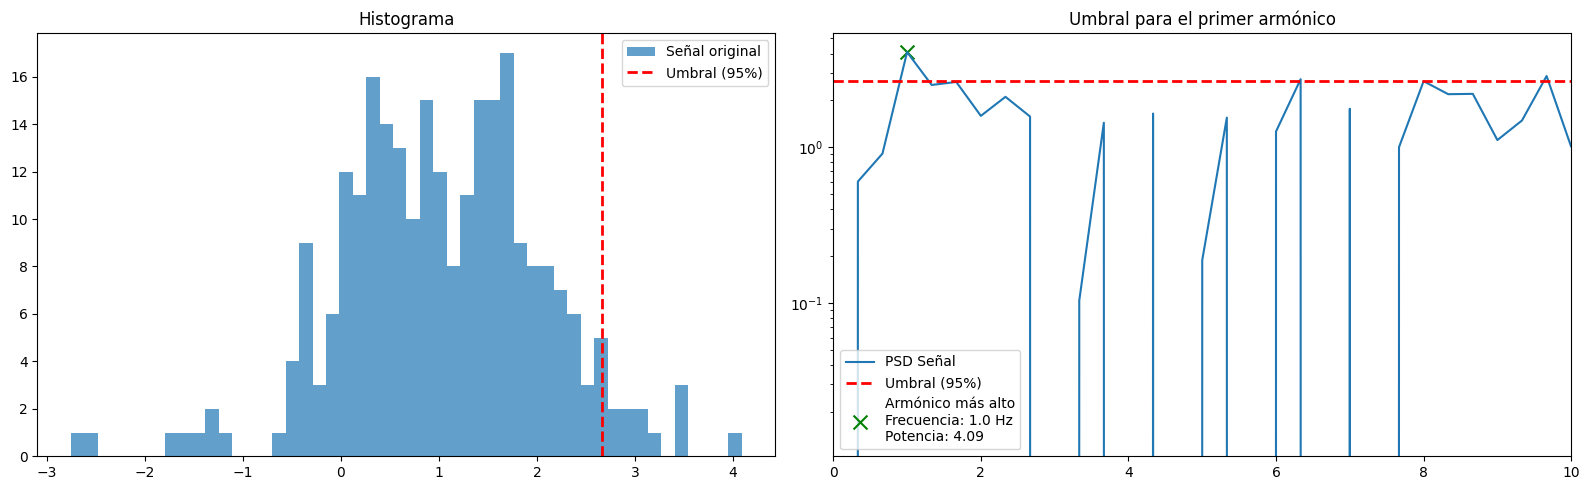

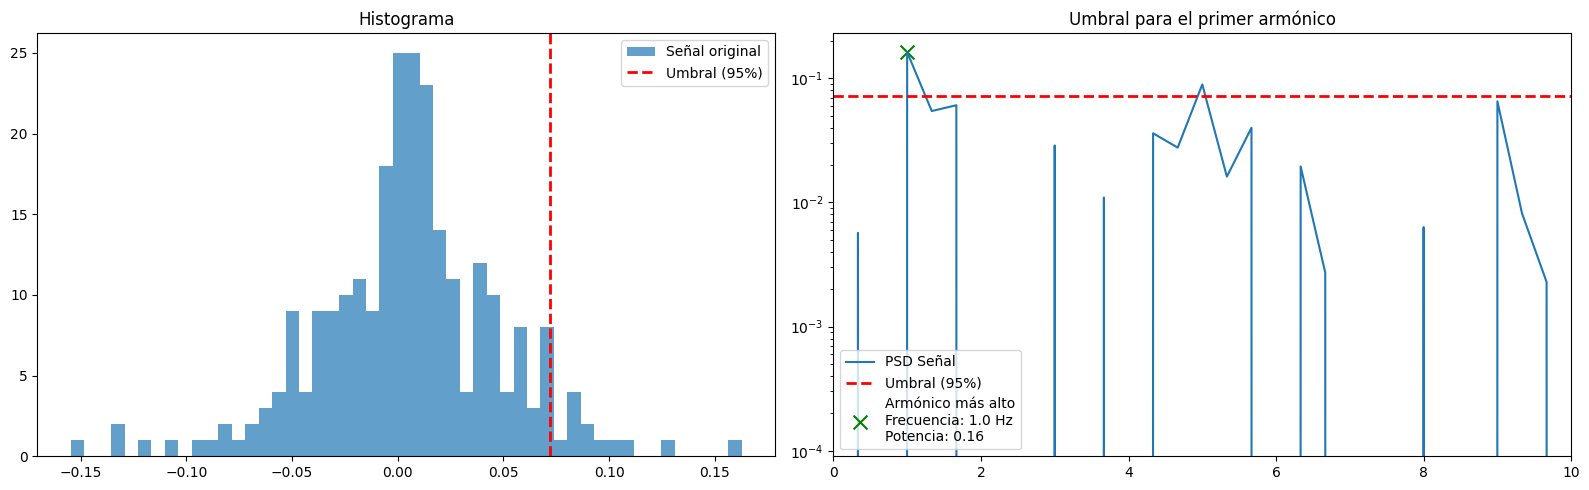

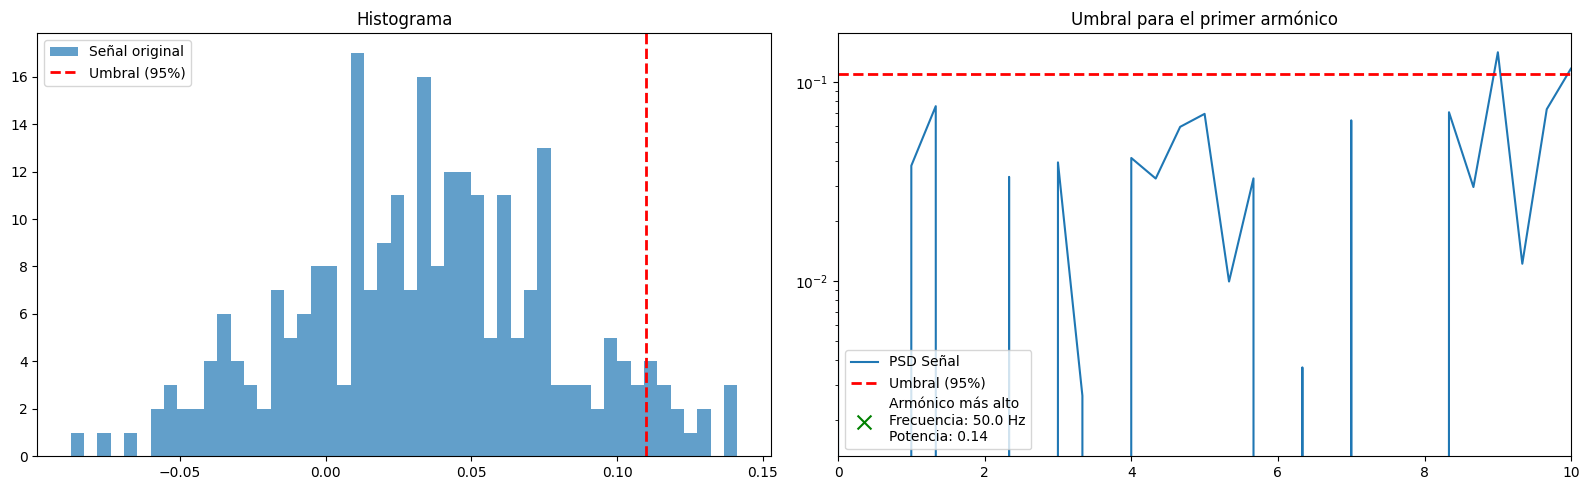

In [ ]:
umbral(y[0]) #MLP (0.1,0.3,0.5)
umbral(y1[0]) #MLP (1,3,5,10,30)
umbral(y2[0]) #LSTM (0.1,0.3,0.5)
umbral(y3[0]) #LSTM (1,3,5,10,30)

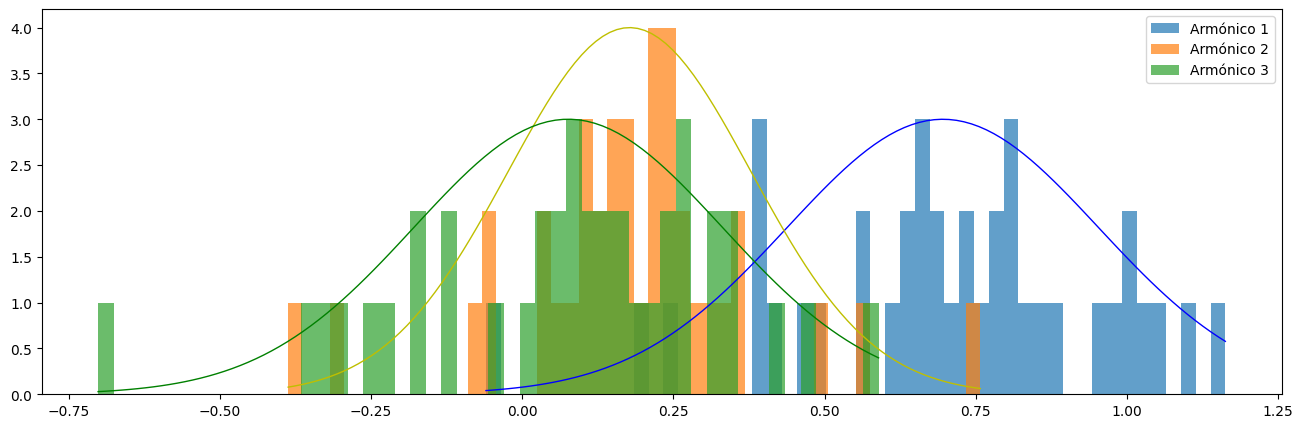

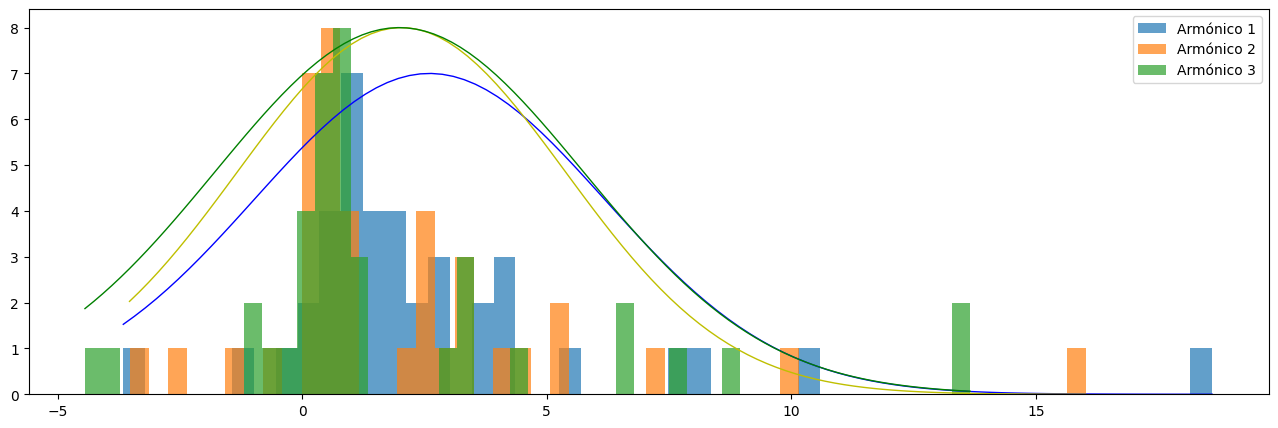

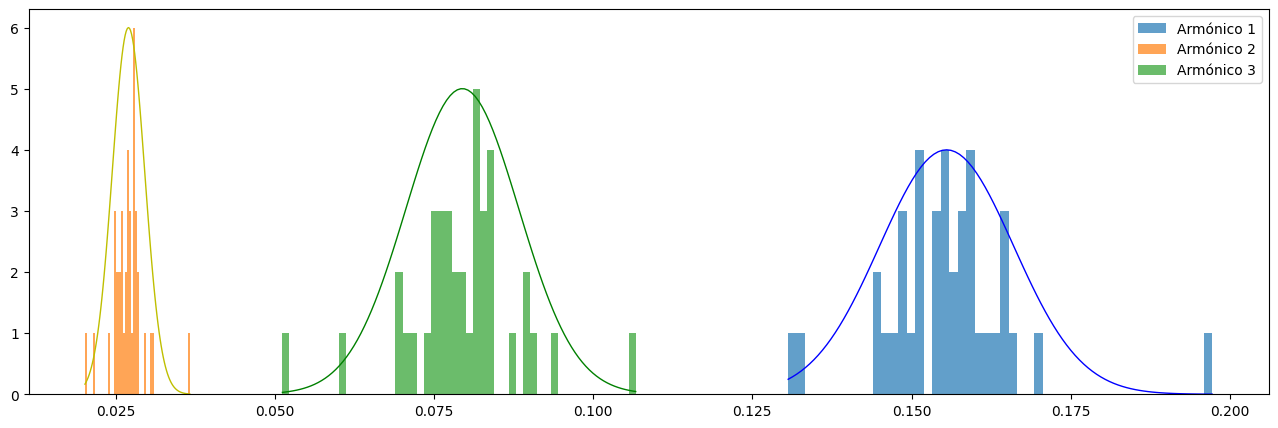

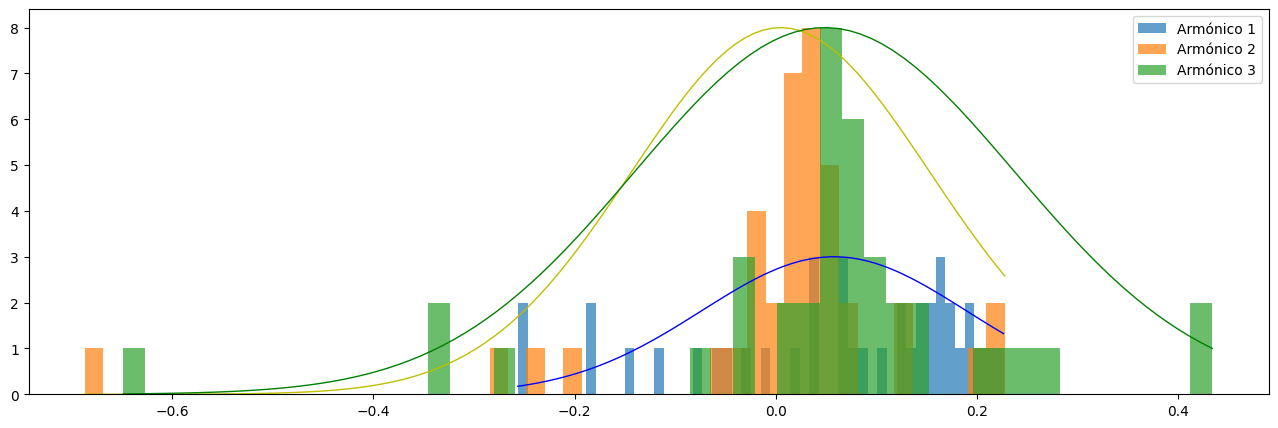

In [ ]:
armonicos(y)
armonicos(y1)
armonicos(y2)
armonicos(y3)

## Tablas y Gráficos (Resultados)

Tabla 1: MLP 1
 ╒════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤═══════════╤═══════════╤══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤══════════╕
│        │        1 │        2 │        3 │        4 │        5 │        6 │        7 │        8 │        9 │       10 │       11 │       12 │       13 │       14 │       15 │       16 │        17 │        18 │       19 │        20 │        21 │        22 │        23 │        24 │        25 │        26 │        27 │        28 │        29 │       30 │
╞════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪═══════════╪═══════════╪══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═════════

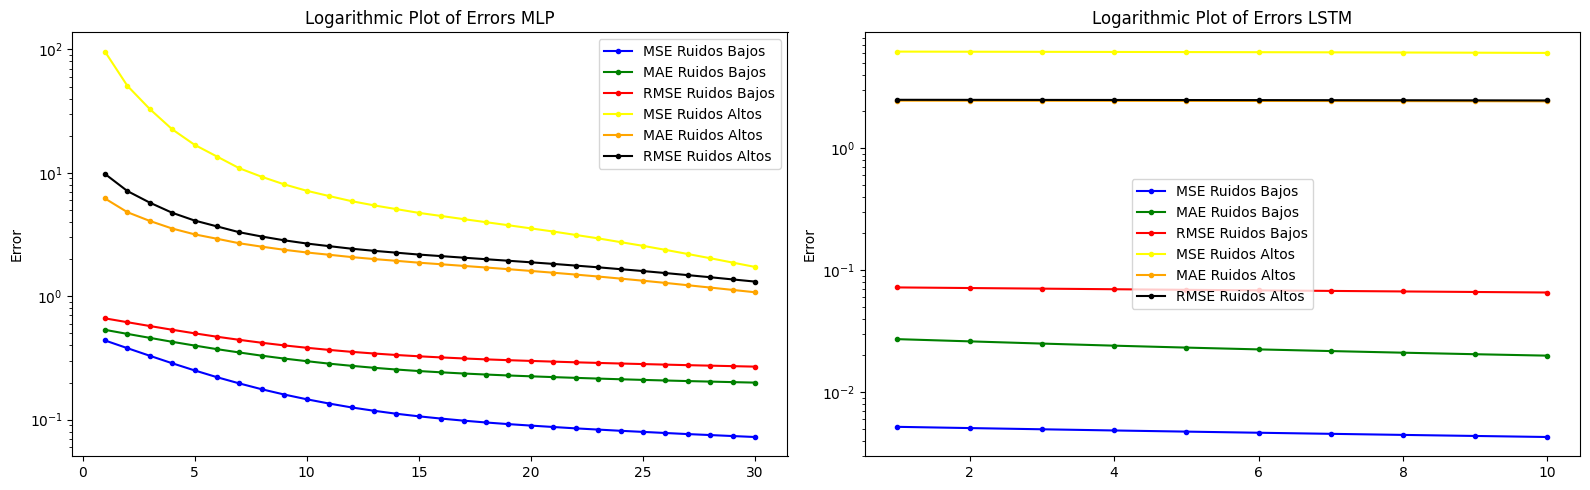

In [ ]:
tablaserror()
tablaresumen()
graficoerrores()

## Reconstrucción

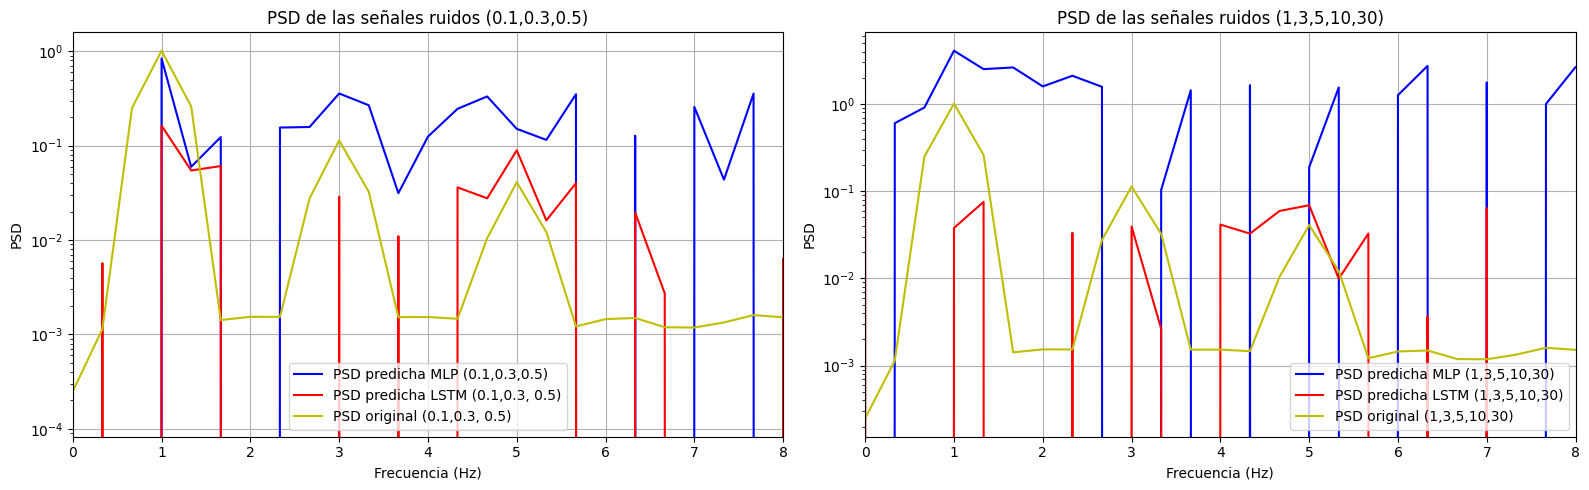

In [ ]:
psdresultados()

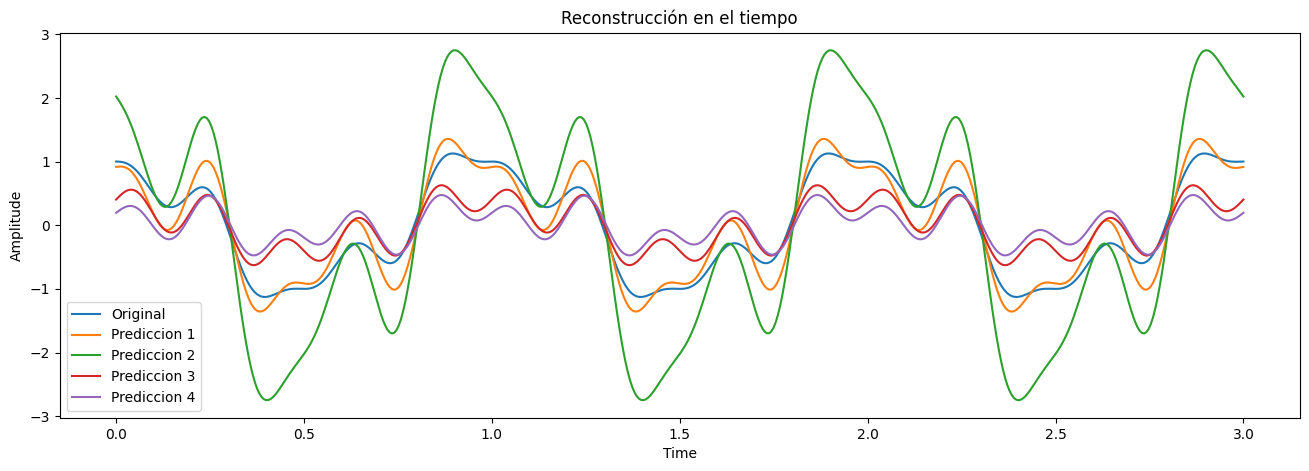

In [ ]:
reconst(0,y,y1,y2,y3)

# Ejercicio Detección

In [ ]:
import numpy as np

def umbral_multiharmonicos(y, fr, percentil=95):
    """
    Esta función detecta los tres primeros armónicos en cada señal, aplica un umbral percentil y
    calcula la probabilidad de detección para cada armónico.

    Entradas:
    y: Lista de señales PSD (cada elemento es una señal)
    fr: Vector de frecuencias
    percentil: Percentil para el umbral (por defecto 95)

    Salidas:
    Imprime la cantidad de armónicos detectados y la probabilidad de detección para cada uno.
    """
    arm1 = []
    arm2 = []
    arm3 = []

    # Detectar los tres armónicos en cada señal
    for i in range(len(y)):
        arm1.append(y[i][np.argmin(np.abs(fr - 1))])
        arm2.append(y[i][np.argmin(np.abs(fr - 3))])
        arm3.append(y[i][np.argmin(np.abs(fr - 5))])

    # Calcular el umbral para cada señal
    umbrales = [np.percentile(signal, percentil) for signal in y]

    # Inicializar contadores de detección
    deteccion_arm1 = 0
    deteccion_arm2 = 0
    deteccion_arm3 = 0

    for i in range(len(y)):
        # Verificar si los armónicos superan el umbral
        if arm1[i] >= umbrales[i]:
            deteccion_arm1 += 1
        if arm2[i] >= umbrales[i]:
            deteccion_arm2 += 1
        if arm3[i] >= umbrales[i]:
            deteccion_arm3 += 1

    # Calcular la probabilidad de detección
    prob_arm1 = deteccion_arm1 / len(y) * 100
    prob_arm2 = deteccion_arm2 / len(y) * 100
    prob_arm3 = deteccion_arm3 / len(y) * 100

    # Imprimir resultados
    print(f"Probabilidad de detección para el primer armónico: {prob_arm1:.2f}%")
    print(f"Probabilidad de detección para el segundo armónico: {prob_arm2:.2f}%")
    print(f"Probabilidad de detección para el tercer armónico: {prob_arm3:.2f}%")
    print(f"Armónicos encontrados en las señales:")
    print(f" - Primer armónico: {deteccion_arm1} de {len(y)} señales.")
    print(f" - Segundo armónico: {deteccion_arm2} de {len(y)} señales.")
    print(f" - Tercer armónico: {deteccion_arm3} de {len(y)} señales.")


umbral_multiharmonicos(y, fr)

Probabilidad de detección para el primer armónico: 79.49%
Probabilidad de detección para el segundo armónico: 15.38%
Probabilidad de detección para el tercer armónico: 7.69%
Armónicos encontrados en las señales:
 - Primer armónico: 31 de 39 señales.
 - Segundo armónico: 6 de 39 señales.
 - Tercer armónico: 3 de 39 señales.


## Fuente:

https://medium.com/@mane-aajay/basics-of-mlp-multilayer-perceptron-f679ac02aa04


https://repositorio.uam.es/bitstream/handle/10486/677854/antona_cortes_carlos_tfg.pdf?sequence=1&isAllowed=y